# Generating molecules at different temperatures

In [1]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore') 

import rdkit
import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

In [2]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

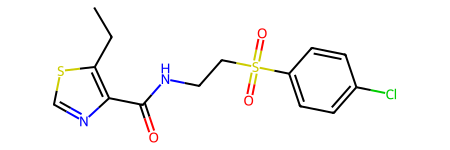

In [46]:
start = designer.design(1)[0]
display(start)
origin = designer.design(start, 1, strategy='grow')[0]

In [8]:
from rdkit.Chem import Draw

def plot_aligned_molecules(
    molecules,
    mols_per_row=3,
    use_svg=True
):
    """
    Plots a list of RDKit molecules.

    Parameters
    ----------
    molecules : list
        A list of RDKit molecule objects.
    """
    mols = [m.mol for m in molecules]
    img = Draw.MolsToGridImage(
        mols,
        subImgSize=(300, 300), # 250
        molsPerRow=mols_per_row,
        useSVG=use_svg,
    )
    return img

In [72]:
from rdkit.Chem import AllChem
import rdkit.Chem.Draw
from rdkit.Chem.Draw import rdMolDraw2D
try:
    import Image
except ImportError:
    from PIL import Image
from io import BytesIO

def DrawMolsZoomed(mols, molsPerRow=3, subImgSize=(500, 500)):
    """
    From https://sourceforge.net/p/rdkit/mailman/message/36477772/
    """
    nRows = len(mols) // molsPerRow
    if len(mols) % molsPerRow: nRows += 1
    fullSize = (molsPerRow * subImgSize[0], nRows * subImgSize[1])
    full_image = Image.new('RGBA', fullSize )
    for ii, mol in enumerate(mols):
        if mol.GetNumConformers() == 0:
            AllChem.Compute2DCoords(mol)
        column = ii % molsPerRow
        row = ii // molsPerRow
        offset = ( column * subImgSize[0], row * subImgSize[1] )
        d2d = rdMolDraw2D.MolDraw2DCairo(int(subImgSize[0] * 0.75), subImgSize[1])
        d2d.DrawMolecule(mol)
        d2d.FinishDrawing()
        sub = Image.open(BytesIO(d2d.GetDrawingText()))
        full_image.paste(sub,box=offset)
    return full_image

In [129]:
designer.reset()
molecules_list = []
for limit in [1, 2, 3]:
    for temperature in [0.0, 0.04, 0.16, 1.0]:
        molecules_ = designer.design(
            origin,
            1,
            strategy='replace',
            limit=limit,
            temperature=temperature
        )
        molecules_list.append(molecules_)

import numpy as np
molecules = np.array(molecules_list).T.ravel()

[18:06:26] Can't kekulize mol.  Unkekulized atoms: 10 13 15 16 18
[18:06:26] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[18:06:26] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[18:06:26] Can't kekulize mol.  Unkekulized atoms: 28 29 31


In [116]:
# DrawMolsZoomed([m.mol for m in molecules], molsPerRow=8)
# svg = plot_aligned_molecules(mols, mols_per_row=1)
# svg
# with open('output.svg', 'w') as f:
#     f.write(svg.data)

In [117]:
from rdkit import Chem
from rdkit.Chem import rdFMCS, AllChem, Draw

def align(molecule, inspiration):
    """
    Recursively aligns a molecule to its chain of inspirations, going back to the first molecule.

    Parameters
    ----------
    molecule : dg.Molecule

    Returns
    -------
    list
        A list of aligned RDKit molecule objects, starting from the origin.
    """    
    # Generate 3D coordinates for all molecules if not already present
    for molecule_ in [molecule, inspiration]:
        mol = molecule_.mol
        AllChem.Compute2DCoords(mol)

    current_mol = molecule.mol
    inspiration_mol = inspiration.mol

    # Find MCS between current molecule and its inspiration
    mcs_result = rdFMCS.FindMCS([current_mol, inspiration_mol])
    mcs_smarts = mcs_result.smartsString
    if not mcs_smarts:
        pass  # Skip if no MCS is found

    mcs_mol = Chem.MolFromSmarts(mcs_smarts)

    # Align the molecule to its inspiration based on MCS
    match1 = current_mol.GetSubstructMatch(mcs_mol)
    match2 = inspiration_mol.GetSubstructMatch(mcs_mol)
    if match1 and match2:
        atom_map = list(zip(match1, match2))
        AllChem.AlignMol(current_mol, inspiration_mol, atomMap=atom_map)

    return molecule

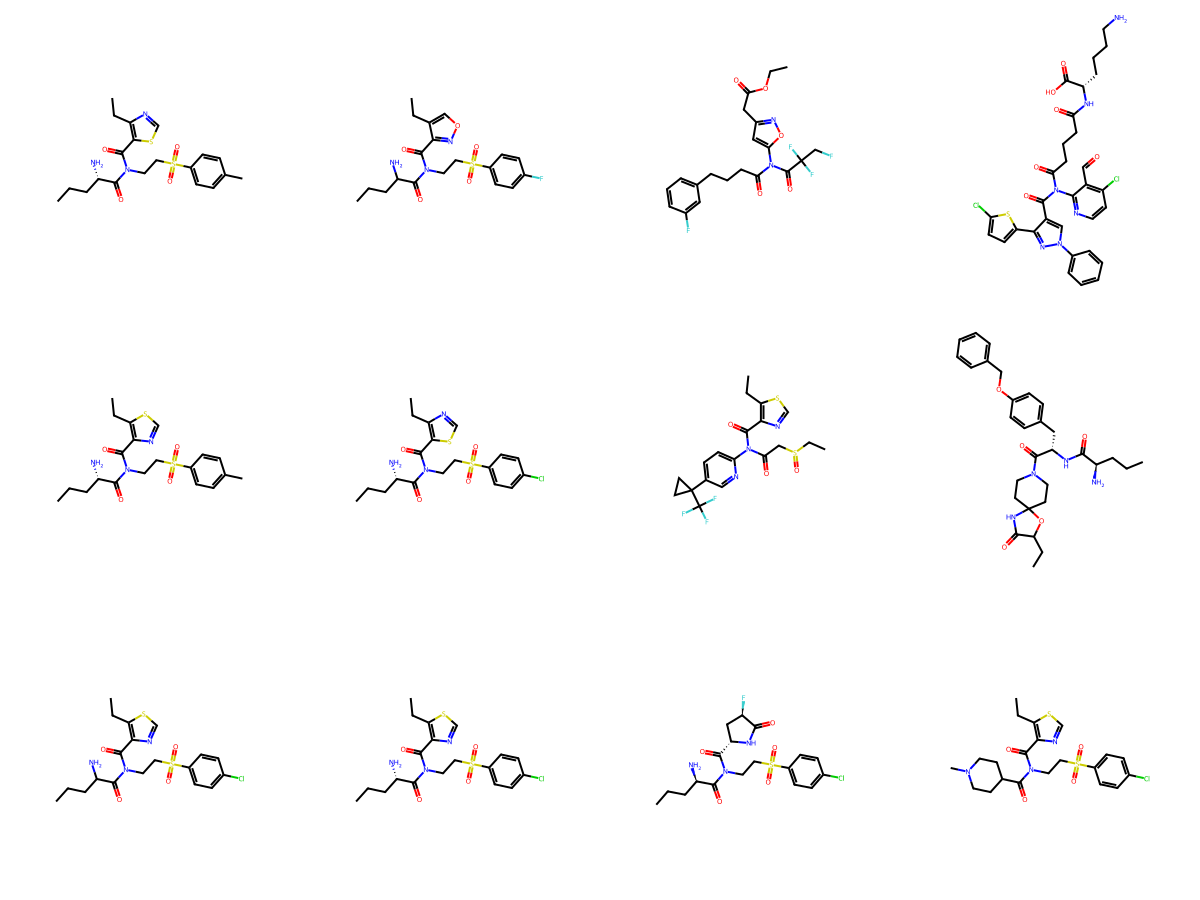

In [154]:
molecules = np.flipud(np.array(molecules_list).reshape(3, -1)).ravel()

for molecule in molecules:
    molecule = align(molecule, origin)

plot_aligned_molecules(molecules, mols_per_row=4)